In [1]:
clean_data = "/kaggle/input/valentini-noisy/clean_testset_wav"
noisy_data = "/kaggle/input/valentini-noisy/noisy_testset_wav"

In [2]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import os

clean_sounds = [os.path.join(clean_data, f) for f in os.listdir(clean_data) if f.endswith('.wav')]
noisy_sounds = [os.path.join(noisy_data, f) for f in os.listdir(noisy_data) if f.endswith('.wav')]


In [3]:
import torchaudio
from torchaudio import transforms
from tqdm import tqdm
import torch

# Initialize lists to store decoded sounds
clean_sounds_list = []
noisy_sounds_list = []

#хз почему, но когда я вставляю нулевой степ внутрь цикла, он зависает, поэтому нулевой отдельно перед циклом
# Decode clean sounds
clean_sounds_list.append(torchaudio.load(clean_sounds[0], channels_first=True)[0])
for i in tqdm(clean_sounds[1:]):
    waveform, _ = torchaudio.load(i, channels_first=True)
    clean_sounds_list.append(waveform)

# Decode noisy sounds
noisy_sounds_list.append(torchaudio.load(noisy_sounds[0], channels_first=True)[0])
for i in tqdm(noisy_sounds[1:]):
    waveform, _ = torchaudio.load(i, channels_first=True)
    noisy_sounds_list.append(waveform)

# -------------- LOAD DATA WITH DOWNSAMPLING --------------

# Decode clean sounds
# waveform, sample_rate = torchaudio.load(clean_sounds[0], channels_first=True)
# transform = transforms.Resample(sample_rate, sample_rate/10)
# waveform = transform(waveform)
# clean_sounds_list.append(waveform)
# for i in tqdm(clean_sounds[1:]):
#     waveform, sample_rate = torchaudio.load(i, channels_first=True)
#     transform = transforms.Resample(sample_rate, sample_rate/10)
#     waveform = transform(waveform)
#     clean_sounds_list.append(waveform)

# # Decode noisy sounds
# waveform, sample_rate = torchaudio.load(noisy_sounds[0], channels_first=True)
# transform = transforms.Resample(sample_rate, sample_rate/10)
# waveform = transform(waveform)
# noisy_sounds_list.append(waveform)
# for i in tqdm(noisy_sounds[1:]):
#     waveform, sample_rate = torchaudio.load(i, channels_first=True)
#     transform = transforms.Resample(sample_rate, sample_rate/10)
#     waveform = transform(waveform)
#     noisy_sounds_list.append(waveform)




100%|██████████| 823/823 [00:19<00:00, 42.68it/s]


In [4]:
clean_sounds_list[3].shape[1]

114930

In [8]:
clean_length = max(sublist.shape[1] for sublist in clean_sounds_list)
noisy_length = max(sublist.shape[1] for sublist in noisy_sounds_list)
clean_length, noisy_length

(46891, 46891)

In [5]:
clean_sounds_list[0].shape

torch.Size([1, 144161])

In [6]:
lenths = [len(sublist.squeeze()) for sublist in clean_sounds_list]
lengths = np.array(lenths)
print("Std: ", np.std(lengths))
print("Mean: ", np.mean(lengths))

Std:  42697.186821170435
Mean:  120700.80339805825


In [7]:
threshold = int(np.mean(lengths) + np.std(lengths))
threshold

163397

In [8]:
tensor = clean_sounds_list[0]
padding_length = max(0, threshold - tensor.shape[1])
pad = torch.zeros((tensor.shape[0], padding_length))
torch.cat([tensor, pad], dim=1).shape

torch.Size([1, 163397])

In [9]:
def trim_pad(sounds_list):

    for i, tensor in enumerate(sounds_list):
        # trimming too long sequences
        if tensor.shape[1] > threshold:
             sounds_list[i] = tensor[:, :threshold]
                
        #padding too short
        padding_length = max(0, threshold - tensor.shape[1])
        if padding_length > 0:
            pad_tensor = torch.zeros((tensor.shape[0], padding_length), dtype=tensor.dtype)
            sounds_list[i] = torch.cat([tensor, pad_tensor], dim=1)

    return sounds_list

In [10]:
len(clean_sounds_list)

824

In [13]:
padded_clean = trim_pad(clean_sounds_list)
padded_noisy = trim_pad(noisy_sounds_list)
max(sublist.shape[1] for sublist in padded_clean), min(sublist.shape[1] for sublist in padded_clean)

(163397, 163397)

In [16]:
np_padded_clean = [tensor.squeeze().numpy() for tensor in padded_clean]
np_padded_noisy = [tensor.squeeze().numpy() for tensor in padded_noisy]
np_padded_clean[0]

array([0.00234985, 0.00271606, 0.00286865, ..., 0.        , 0.        ,
       0.        ], dtype=float32)

In [32]:
def draw_spec(spec):
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(spec, sr=48000, x_axis='time', y_axis='log')
    plt.colorbar()

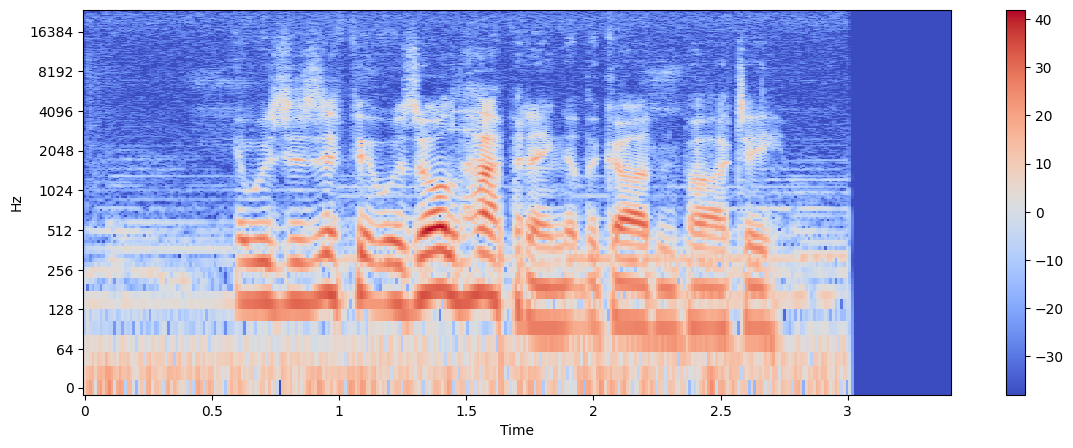

In [33]:
# Demo sample of noisy spectrogram
X = librosa.stft(np_padded_noisy[0])
Xdb = librosa.amplitude_to_db(abs(X))
draw_spec(Xdb)

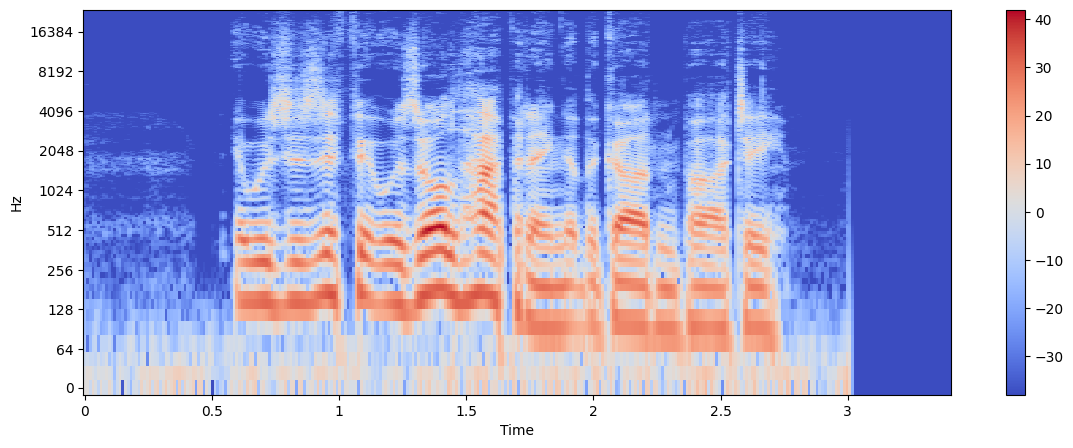

In [34]:
# Demo sample of clean spectrogram
X = librosa.stft(np_padded_clean[0])
Xdb = librosa.amplitude_to_db(abs(X))
draw_spec(Xdb)

In [24]:
print(f'Audio shape: {np_padded_clean[0].shape}')
print(f'Spectrogram shape: {Xdb.shape}')

Audio shape: (163397,)
Spectrogram shape: (1025, 320)


In [29]:
def get_stft(waveforms: list) -> list:
    '''params: waveforms - list of waveforms represented as numpy arrays
    output: list of spectrograms'''
    specs = []
    for wav in waveforms:
        stft = librosa.amplitude_to_db(abs(librosa.stft(wav)))
        specs.append(stft)
        
    return specs

In [30]:
clean_specs = get_stft(np_padded_clean)
noisy_specs = get_stft(np_padded_noisy)

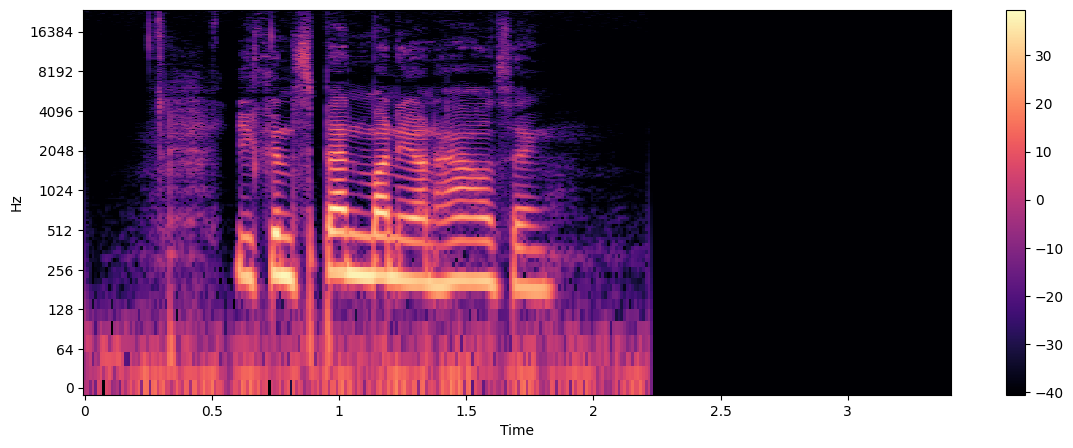

In [40]:
draw_spec(clean_specs[10])

In [43]:
np_clean_specs = np.array(clean_specs)
np_noisy_specs = np.array(noisy_specs)

In [48]:
import pickle

with open('clean_specs.pkl', 'wb') as f:
    pickle.dump(np_clean_specs, f)
    
with open('noisy_specs.pkl', 'wb') as f:
    pickle.dump(np_noisy_specs, f)

In [ ]:
# Load saved spectrograms
# with open('clean_specs.pkl', 'rb') as f:
#     loaded_clean_specs = pickle.load(f)
# 
# with open('noisy_specs.pkl', 'rb') as f:
#     loaded_noisy_specs = pickle.load(f)